In [1]:
!pip install transformers datasets accelerate torch bitsandbytes evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, PeftModel
import copy
import os
import time
import pandas as pd

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Model Settings
MODEL_NAME = "gpt2"  # Can change to gpt2-medium if you have enough memory
PRUNING_RATIO = 0.3  # Prune 30% of layers

# Dataset Settings
CALIBRATION_DATASET = "wikitext"
CALIBRATION_DATASET_CONFIG = "wikitext-2-raw-v1"
CALIBRATION_SPLIT = "test"
NUM_CALIBRATION_SAMPLES = 16
MAX_CALIBRATION_LENGTH = 128

# LoRA Settings
LORA_RANK = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["c_attn", "c_proj"] # Target both attention and projection matrices

# Paths
OUTPUT_DIR = "./pruned_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Helper Functions ---
def count_parameters(model, only_trainable=False):
    """Count the number of trainable parameters in a model."""
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def get_model_size_mb(model):
    """Estimate the model size in megabytes."""
    num_params = count_parameters(model)
    # Assuming float32 (4 bytes per parameter)
    size_bytes = num_params * 4
    return size_bytes / (1024 * 1024)

def time_inference(model, input_tensor, num_runs=10):
    """Measure the average inference time."""
    model.eval()
    # Warm-up
    with torch.no_grad():
        _ = model(input_tensor)

    # Time measurement
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()

    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Convert to milliseconds

def get_dataset(dataset_name, config_name, split, tokenizer, num_samples, max_length):
    """Loads and preprocesses the dataset."""
    print(f"Loading dataset: {dataset_name} ({config_name}) - {split} split")
    dataset = load_dataset(dataset_name, config_name, split=split)

    # Use a subset for calibration
    if num_samples < len(dataset):
        dataset = dataset.select(range(num_samples))

    print(f"Tokenizing {len(dataset)} samples...")

    def tokenize_function(examples):
        # Concatenate all texts and tokenize
        text = " ".join(examples["text"])
        tokenized = tokenizer(text, truncation=True, max_length=max_length * len(examples["text"]))

        # Split into chunks of max_length
        result = {
            "input_ids": [tokenized["input_ids"][i:i+max_length] for i in range(0, len(tokenized["input_ids"]), max_length)],
            "attention_mask": [tokenized["attention_mask"][i:i+max_length] for i in range(0, len(tokenized["attention_mask"]), max_length)]
        }

        # Add labels for language modeling
        result["labels"] = result["input_ids"].copy()
        return result

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

    print(f"Finished tokenizing. Dataset size: {len(tokenized_dataset)}")
    return tokenized_dataset

def calculate_perplexity(model, dataset, device, model_name="model"):
    """Calculates perplexity for a model on a given dataset."""
    print(f"Calculating perplexity for: {model_name}")
    model.eval()
    model.to(device)

    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataset, desc=f"Perplexity ({model_name})"):
            input_ids = torch.tensor(batch['input_ids']).unsqueeze(0).to(device)
            labels = torch.tensor(batch['labels']).unsqueeze(0).to(device)

            try:
                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs.loss

                # Count tokens excluding padding
                num_tokens = (labels != -100).sum().item()

                if num_tokens > 0:
                    total_loss += loss.item() * num_tokens
                    total_tokens += num_tokens

            except Exception as e:
                print(f"Error during forward pass: {e}")
                continue

            # Clear CUDA cache periodically
            if device.type == "cuda":
                torch.cuda.empty_cache()

    if total_tokens == 0:
        print("Warning: No tokens were processed for perplexity calculation.")
        return float('inf')

    avg_loss = total_loss / total_tokens
    ppl = math.exp(avg_loss)
    print(f"{model_name} - Avg Loss: {avg_loss:.4f}, Perplexity: {ppl:.4f}")
    return ppl

def plot_before_after_metrics(before_metrics, after_metrics, title="Before vs. After Comparison"):
    """Plot before and after metrics comparison."""
    metrics = [
        ('Parameters (M)', before_metrics['parameters'] / 1_000_000, after_metrics['parameters'] / 1_000_000),
        ('Model Size (MB)', before_metrics['model_size'], after_metrics['model_size']),
        ('Perplexity', before_metrics['perplexity'], after_metrics['perplexity']),
        ('Inference Time (ms)', before_metrics['inference_time'], after_metrics['inference_time'])
    ]

    # Calculate percentage changes
    for i, (name, before, after) in enumerate(metrics):
        if before != 0:  # Avoid division by zero
            pct_change = ((after - before) / before) * 100
            metrics[i] = (name, before, after, pct_change)
        else:
            metrics[i] = (name, before, after, 0)

    # Create comparison table as a figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    # Create table data
    table_data = [
        ['Metric', 'Before', 'After', 'Change (%)', 'Result']
    ]

    for name, before, after, pct_change in metrics:
        result = '✓ Better' if (name == 'Perplexity' and after <= before) or \
                             (name != 'Perplexity' and after < before) else '✗ Worse'

        # Format values
        if name == 'Parameters (M)' or name == 'Model Size (MB)':
            before_str = f"{before:.2f}"
            after_str = f"{after:.2f}"
        elif name == 'Perplexity':
            before_str = f"{before:.4f}"
            after_str = f"{after:.4f}"
        else:
            before_str = f"{before:.2f}"
            after_str = f"{after:.2f}"

        table_data.append([name, before_str, after_str, f"{pct_change:.2f}%", result])

    # Create table
    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                  colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Color the header row
    for j in range(len(table_data[0])):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(color='white')

    # Color the result cells based on better/worse
    for i in range(1, len(table_data)):
        if '✓' in table_data[i][4]:
            table[(i, 4)].set_facecolor('#C6EFCE')
        else:
            table[(i, 4)].set_facecolor('#FFC7CE')

    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    return plt

Using device: cuda


In [3]:
def get_model_layers(model):
    """Returns the list of decoder layers/blocks for GPT-2."""
    return model.transformer.h

def set_model_layers(model, layers):
    """Sets the decoder layers/blocks for GPT-2."""
    model.transformer.h = layers
    # Update model config num_hidden_layers
    model.config.num_hidden_layers = len(layers)

def calculate_block_importance(model, dataset, device):
    """
    Calculates block importance based on perplexity increase when the block is removed.
    Lower perplexity means LESS important, as its removal hurts performance less.
    """
    print("\nCalculating block importance...")
    original_layers = get_model_layers(model)
    num_layers = len(original_layers)
    importances = {}
    layer_metrics = {}

    # Heuristic: Define blocks to always keep
    keep_first_n = 1
    keep_last_m = 1
    prunable_indices = list(range(keep_first_n, num_layers - keep_last_m))

    print(f"Original number of layers: {num_layers}")
    print(f"Keeping first {keep_first_n} and last {keep_last_m} layers.")
    print(f"Evaluating importance for layers: {prunable_indices}")

    # Create sample input for time measurement
    sample_input = torch.randint(0, model.config.vocab_size, (1, 32)).to(device)

    for i in tqdm(range(num_layers), desc="Evaluating Block Importance"):
        if i not in prunable_indices:
            print(f"Skipping layer {i} (heuristic protection).")
            importances[i] = float('-inf')  # Mark as non-prunable
            layer_metrics[i] = {
                'status': 'protected',
                'perplexity': float('inf'),
                'param_count': sum(p.numel() for p in original_layers[i].parameters())
            }
            continue

        print(f"\nEvaluating importance of layer {i}")

        # Create temporary model without layer i
        temp_model = copy.deepcopy(model)
        temp_model.to(torch.device('cpu'))

        # Get parameter count before removal
        param_count_before = count_parameters(temp_model)

        temp_layers = list(get_model_layers(temp_model))
        removed_layer = temp_layers.pop(i)
        layer_param_count = sum(p.numel() for p in removed_layer.parameters())

        # Update model with removed layer
        set_model_layers(temp_model, torch.nn.ModuleList(temp_layers))

        # Move model back to device for evaluation
        temp_model.to(device)

        # Calculate perplexity without this layer
        ppl_without_layer = calculate_perplexity(temp_model, dataset, device, f"Layer {i} removed")

        # Store metrics
        importances[i] = ppl_without_layer
        layer_metrics[i] = {
            'status': 'evaluated',
            'perplexity': ppl_without_layer,
            'param_count': layer_param_count
        }

        print(f"Layer {i} removed -> Perplexity: {ppl_without_layer:.4f}")
        print(f"Layer {i} parameters: {layer_param_count:,}")

        # Clean up
        del temp_model
        del removed_layer
        del temp_layers
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Restore original layers (though we used deepcopy)
    set_model_layers(model, original_layers)

    print("\nBlock Importance Scores (Perplexity after removal):")
    for i in sorted(importances.keys()):
        score = importances[i]
        if score == float('-inf'):
            print(f"  Layer {i}: Protected (Heuristic)")
        else:
            print(f"  Layer {i}: {score:.4f}")

    return importances, layer_metrics

def prune_model(model, num_blocks_to_prune, importances):
    """Prunes the model by removing blocks with lowest importance scores."""

    original_layers = get_model_layers(model)
    num_original_layers = len(original_layers)
    print(f"\nStarting one-shot pruning...")
    print(f"Original layer count: {num_original_layers}")
    print(f"Target number of blocks to prune: {num_blocks_to_prune}")

    if num_blocks_to_prune <= 0:
        print("No blocks to prune.")
        return model, []

    # Filter out protected layers and sort by importance
    prunable_layers_sorted = sorted(
        [(score, idx) for idx, score in importances.items() if score != float('-inf')]
    )

    actual_num_to_prune = min(num_blocks_to_prune, len(prunable_layers_sorted))

    if actual_num_to_prune == 0:
        print("No prunable layers available based on importance scores.")
        return model, []

    print(f"Actual number of blocks to prune: {actual_num_to_prune}")

    # Get indices to remove (those with lowest PPL scores after removal)
    indices_to_remove = {idx for score, idx in prunable_layers_sorted[:actual_num_to_prune]}

    print(f"Indices identified for removal: {sorted(list(indices_to_remove))}")

    # Create new list of layers, excluding ones to remove
    new_layers = [layer for i, layer in enumerate(original_layers) if i not in indices_to_remove]

    # Update model layers
    set_model_layers(model, torch.nn.ModuleList(new_layers))

    num_final_layers = len(get_model_layers(model))
    print(f"Pruning complete. Final layer count: {num_final_layers}")

    return model, sorted(list(indices_to_remove))

def save_pruned_model(model, tokenizer, output_dir):
    """Saves the pruned model and tokenizer."""
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving pruned model to: {output_dir}")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print("Model and tokenizer saved successfully")


GPT-2 MODEL PRUNING EXPERIMENT
Loading model: gpt2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


ORIGINAL MODEL STATISTICS
--------------------------------------------------
Model Type: gpt2
Number of Parameters: 124,439,808
Model Size: 474.70 MB
Number of Layers: 12
Hidden Size: 768
Baseline Inference Time: 10.28 ms
Loading dataset: wikitext (wikitext-2-raw-v1) - test split


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing 16 samples...


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Finished tokenizing. Dataset size: 7

Calculating baseline perplexity...
Calculating perplexity for: Original Model


Perplexity (Original Model):   0%|          | 0/7 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Original Model - Avg Loss: 4.1312, Perplexity: 62.2545
Baseline Perplexity: 62.2545

Calculating block importance...
Original number of layers: 12
Keeping first 1 and last 1 layers.
Evaluating importance for layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Evaluating Block Importance:   0%|          | 0/12 [00:00<?, ?it/s]

Skipping layer 0 (heuristic protection).

Evaluating importance of layer 1
Calculating perplexity for: Layer 1 removed


Perplexity (Layer 1 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 1 removed - Avg Loss: 4.1530, Perplexity: 63.6223
Layer 1 removed -> Perplexity: 63.6223
Layer 1 parameters: 7,087,872

Evaluating importance of layer 2
Calculating perplexity for: Layer 2 removed


Perplexity (Layer 2 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 2 removed - Avg Loss: 4.1883, Perplexity: 65.9088
Layer 2 removed -> Perplexity: 65.9088
Layer 2 parameters: 7,087,872

Evaluating importance of layer 3
Calculating perplexity for: Layer 3 removed


Perplexity (Layer 3 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 3 removed - Avg Loss: 4.1885, Perplexity: 65.9238
Layer 3 removed -> Perplexity: 65.9238
Layer 3 parameters: 7,087,872

Evaluating importance of layer 4
Calculating perplexity for: Layer 4 removed


Perplexity (Layer 4 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 4 removed - Avg Loss: 4.2689, Perplexity: 71.4422
Layer 4 removed -> Perplexity: 71.4422
Layer 4 parameters: 7,087,872

Evaluating importance of layer 5
Calculating perplexity for: Layer 5 removed


Perplexity (Layer 5 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 5 removed - Avg Loss: 4.2544, Perplexity: 70.4122
Layer 5 removed -> Perplexity: 70.4122
Layer 5 parameters: 7,087,872

Evaluating importance of layer 6
Calculating perplexity for: Layer 6 removed


Perplexity (Layer 6 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 6 removed - Avg Loss: 4.1971, Perplexity: 66.4921
Layer 6 removed -> Perplexity: 66.4921
Layer 6 parameters: 7,087,872

Evaluating importance of layer 7
Calculating perplexity for: Layer 7 removed


Perplexity (Layer 7 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 7 removed - Avg Loss: 4.2395, Perplexity: 69.3708
Layer 7 removed -> Perplexity: 69.3708
Layer 7 parameters: 7,087,872

Evaluating importance of layer 8
Calculating perplexity for: Layer 8 removed


Perplexity (Layer 8 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 8 removed - Avg Loss: 4.3145, Perplexity: 74.7740
Layer 8 removed -> Perplexity: 74.7740
Layer 8 parameters: 7,087,872

Evaluating importance of layer 9
Calculating perplexity for: Layer 9 removed


Perplexity (Layer 9 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 9 removed - Avg Loss: 4.3360, Perplexity: 76.4018
Layer 9 removed -> Perplexity: 76.4018
Layer 9 parameters: 7,087,872

Evaluating importance of layer 10
Calculating perplexity for: Layer 10 removed


Perplexity (Layer 10 removed):   0%|          | 0/7 [00:00<?, ?it/s]

Layer 10 removed - Avg Loss: 4.2835, Perplexity: 72.4923
Layer 10 removed -> Perplexity: 72.4923
Layer 10 parameters: 7,087,872
Skipping layer 11 (heuristic protection).

Block Importance Scores (Perplexity after removal):
  Layer 0: Protected (Heuristic)
  Layer 1: 63.6223
  Layer 2: 65.9088
  Layer 3: 65.9238
  Layer 4: 71.4422
  Layer 5: 70.4122
  Layer 6: 66.4921
  Layer 7: 69.3708
  Layer 8: 74.7740
  Layer 9: 76.4018
  Layer 10: 72.4923
  Layer 11: Protected (Heuristic)

Starting one-shot pruning...
Original layer count: 12
Target number of blocks to prune: 3
Actual number of blocks to prune: 3
Indices identified for removal: [1, 2, 3]
Pruning complete. Final layer count: 9

PRUNED MODEL STATISTICS
--------------------------------------------------
Number of Parameters: 103,176,192
Model Size: 393.59 MB
Number of Layers: 9
Parameter Reduction: 21,263,616 (17.09%)
Pruned Model Inference Time: 11.10 ms
Inference Speedup: 0.93x

Calculating perplexity after pruning...
Calculating pe

Perplexity (Pruned Model):   0%|          | 0/7 [00:00<?, ?it/s]

Pruned Model - Avg Loss: 5.2335, Perplexity: 187.4432
Pruned Model Perplexity: 187.4432
Perplexity Change: 125.1887 (201.09%)
Saving pruned model to: ./pruned_models/gpt2-pruned-3layers
Model and tokenizer saved successfully


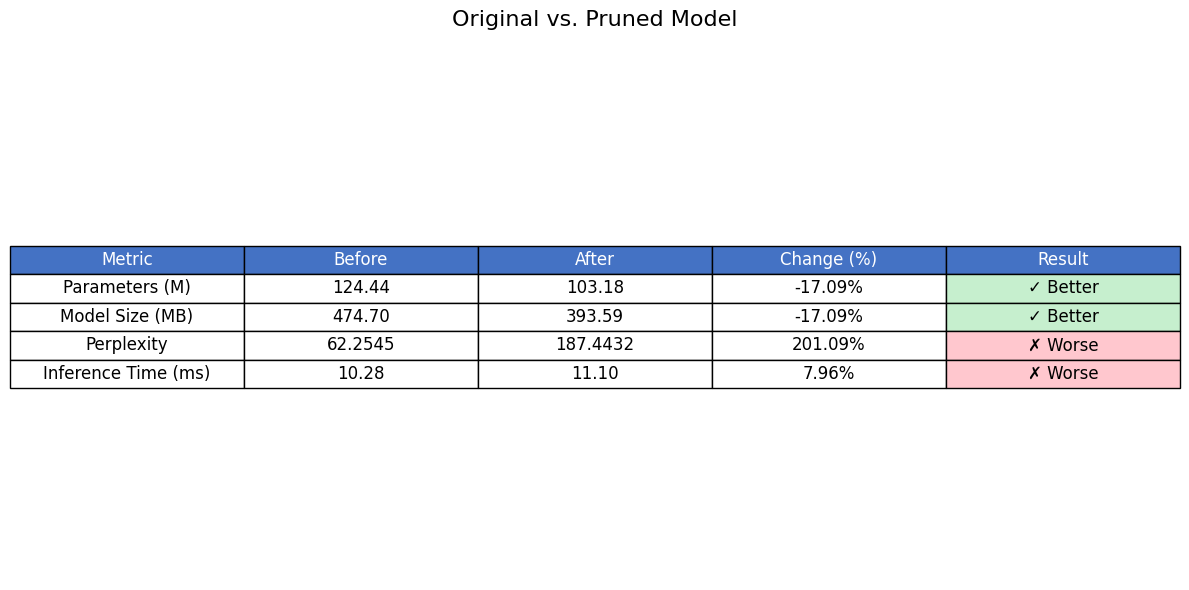


PRUNING SUMMARY
Original Model: gpt2
Original Parameters: 124,439,808
Pruned Parameters: 103,176,192
Removed Layers: [1, 2, 3]


In [4]:
def run_pruning_process():
    print("\n" + "="*50)
    print(f"GPT-2 MODEL PRUNING EXPERIMENT")
    print("="*50)

    # Load model and tokenizer
    print(f"Loading model: {MODEL_NAME}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

    # Get initial model statistics
    original_param_count = count_parameters(model)
    original_model_size = get_model_size_mb(model)
    num_layers = len(get_model_layers(model))

    print("\nORIGINAL MODEL STATISTICS")
    print("-"*50)
    print(f"Model Type: {model.config.model_type}")
    print(f"Number of Parameters: {original_param_count:,}")
    print(f"Model Size: {original_model_size:.2f} MB")
    print(f"Number of Layers: {num_layers}")
    print(f"Hidden Size: {model.config.hidden_size}")

    # Create sample input for inference time measurement
    sample_input = torch.randint(0, model.config.vocab_size, (1, 32))

    # Move model to device
    model.to(DEVICE)
    sample_input = sample_input.to(DEVICE)

    # Measure baseline inference time
    baseline_inference_time = time_inference(model, sample_input)
    print(f"Baseline Inference Time: {baseline_inference_time:.2f} ms")

    # Load and preprocess dataset
    calibration_dataset = get_dataset(
        CALIBRATION_DATASET, CALIBRATION_DATASET_CONFIG, CALIBRATION_SPLIT,
        tokenizer, NUM_CALIBRATION_SAMPLES, MAX_CALIBRATION_LENGTH
    )

    # Calculate initial perplexity
    print("\nCalculating baseline perplexity...")
    baseline_ppl = calculate_perplexity(model, calibration_dataset, DEVICE, "Original Model")
    print(f"Baseline Perplexity: {baseline_ppl:.4f}")

    # Calculate layer importance
    importances, _ = calculate_block_importance(model, calibration_dataset, DEVICE)

    # Determine pruning amount
    num_layers = len(get_model_layers(model))
    prunable_count = sum(1 for score in importances.values() if score != float('-inf'))
    num_to_prune = min(max(0, int(num_layers * PRUNING_RATIO)), prunable_count)

    # Prune model
    model_pruned, removed_indices = prune_model(model, num_to_prune, importances)

    # Get pruned model statistics
    pruned_param_count = count_parameters(model_pruned)
    pruned_model_size = get_model_size_mb(model_pruned)
    pruned_layers = len(get_model_layers(model_pruned))

    print("\nPRUNED MODEL STATISTICS")
    print("-"*50)
    print(f"Number of Parameters: {pruned_param_count:,}")
    print(f"Model Size: {pruned_model_size:.2f} MB")
    print(f"Number of Layers: {pruned_layers}")
    print(f"Parameter Reduction: {original_param_count - pruned_param_count:,} ({(1 - pruned_param_count / original_param_count) * 100:.2f}%)")

    # Measure pruned model inference time
    pruned_inference_time = time_inference(model_pruned, sample_input)
    print(f"Pruned Model Inference Time: {pruned_inference_time:.2f} ms")
    print(f"Inference Speedup: {baseline_inference_time / pruned_inference_time:.2f}x")

    # Verify performance after pruning
    print("\nCalculating perplexity after pruning...")
    pruned_ppl = calculate_perplexity(model_pruned, calibration_dataset, DEVICE, "Pruned Model")
    print(f"Pruned Model Perplexity: {pruned_ppl:.4f}")
    print(f"Perplexity Change: {pruned_ppl - baseline_ppl:.4f} ({(pruned_ppl / baseline_ppl - 1) * 100:.2f}%)")

    # Save pruned model
    pruned_model_path = os.path.join(OUTPUT_DIR, f"{MODEL_NAME}-pruned-{num_to_prune}layers")
    save_pruned_model(model_pruned, tokenizer, pruned_model_path)

    # Create before/after metrics comparison
    before_metrics = {
        'parameters': original_param_count,
        'model_size': original_model_size,
        'perplexity': baseline_ppl,
        'inference_time': baseline_inference_time
    }

    after_metrics = {
        'parameters': pruned_param_count,
        'model_size': pruned_model_size,
        'perplexity': pruned_ppl,
        'inference_time': pruned_inference_time
    }

    plt_comparison = plot_before_after_metrics(before_metrics, after_metrics, "Original vs. Pruned Model")
    plt_comparison.savefig('original_vs_pruned_comparison.png')
    plt_comparison.show()

    print("\nPRUNING SUMMARY")
    print("="*50)
    print(f"Original Model: {MODEL_NAME}")
    print(f"Original Parameters: {original_param_count:,}")
    print(f"Pruned Parameters: {pruned_param_count:,}")
    print(f"Removed Layers: {removed_indices}")

    return {
        'model_name': MODEL_NAME,
        'pruned_model_path': pruned_model_path,
        'removed_indices': removed_indices,
        'num_to_prune': num_to_prune,
        'original_metrics': before_metrics,
        'pruned_metrics': after_metrics,
        'tokenizer': tokenizer,
        'pruned_model': model_pruned  # Return the model for further processing
    }

# Run pruning process
pruning_results = run_pruning_process()

In [5]:
def run_lora_training(pruning_results):
    print("\n" + "="*50)
    print("LoRA FINE-TUNING ON PRUNED MODEL")
    print("="*50)

    # Extract results from pruning
    pruned_model = pruning_results['pruned_model']
    tokenizer = pruning_results['tokenizer']
    pruned_model_path = pruning_results['pruned_model_path']
    num_to_prune = pruning_results['num_to_prune']

    # LoRA Hyperparameters
    OUTPUT_DIR_LORA = os.path.join(OUTPUT_DIR, f"{MODEL_NAME}-pruned-{num_to_prune}layers-lora")
    os.makedirs(OUTPUT_DIR_LORA, exist_ok=True)

    # Alpaca-style dataset for instruction tuning
    ALPACA_DATASET = "yahma/alpaca-cleaned"
    ALPACA_MAX_SAMPLES = 2000  # Use a smaller subset for faster training
    ALPACA_MAX_LENGTH = 512    # Max sequence length for training

    # Training parameters
    PAPER_LR = 2e-4            # Higher learning rate for better adaptation
    PAPER_EPOCHS = 3           # More epochs to ensure learning
    PER_DEVICE_BATCH_SIZE = 4  # Adjust based on memory
    GRADIENT_ACCUMULATION_STEPS = 8  # Effective batch size of 32

    print(f"Loading base pruned model from: {pruned_model_path}")

    # Load the ALPACA dataset for instruction tuning
    print(f"Loading dataset: {ALPACA_DATASET}")
    try:
        alpaca_dataset = load_dataset(ALPACA_DATASET, split="train")

        # Select a subset for faster training
        if ALPACA_MAX_SAMPLES < len(alpaca_dataset):
            alpaca_dataset = alpaca_dataset.select(range(ALPACA_MAX_SAMPLES))
        print(f"Using {len(alpaca_dataset)} samples for LoRA training.")

        # Preprocess Alpaca dataset
        def format_alpaca(sample):
            instruction = sample.get('instruction', '')
            input_text = sample.get('input', '')
            output_text = sample.get('output', '')

            if input_text:
                text = f"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n{output_text}"
            else:
                text = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n{output_text}"
            return {"text": text + tokenizer.eos_token}

        # Apply formatting
        alpaca_dataset = alpaca_dataset.map(format_alpaca)

        # Tokenize the formatted text
        print("Tokenizing dataset...")
        def tokenize_alpaca(element):
            outputs = tokenizer(
                element['text'],
                truncation=True,
                max_length=ALPACA_MAX_LENGTH,
                padding=False,
                return_tensors=None,
            )
            return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

        tokenized_dataset = alpaca_dataset.map(
            tokenize_alpaca,
            batched=True,
            remove_columns=[col for col in alpaca_dataset.column_names if col != 'input_ids' and col != 'attention_mask']
        )
        print(f"Tokenization complete. Example input_ids length: {len(tokenized_dataset[0]['input_ids'])}")

        # Define LoRA configuration - targeting more attention components
        lora_config = LoraConfig(
            r=LORA_RANK,                    # Rank dimension
            lora_alpha=LORA_ALPHA,          # Alpha parameter for LoRA scaling
            target_modules=LORA_TARGET_MODULES,  # Which modules to apply LoRA to
            lora_dropout=LORA_DROPOUT,      # Dropout probability for LoRA layers
            bias="none",                    # Don't use bias terms
            task_type="CAUSAL_LM"           # Language modeling task
        )

        # Apply LoRA adapters to the pruned model
        print("Applying LoRA adapters...")
        pruned_model.to(DEVICE)  # Move to device before PEFT application
        lora_model = get_peft_model(pruned_model, lora_config)

        # Print trainable parameters info
        trainable_params = count_parameters(lora_model, only_trainable=True)
        total_params = count_parameters(lora_model, only_trainable=False)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")

        # Set up trainer
        training_args = TrainingArguments(
            output_dir=OUTPUT_DIR_LORA,
            per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
            gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
            learning_rate=PAPER_LR,
            num_train_epochs=PAPER_EPOCHS,
            logging_steps=50,
            save_strategy="epoch",
            fp16=torch.cuda.is_available(),
            warmup_ratio=0.05,
            lr_scheduler_type="cosine",  # Cosine scheduler works better
            save_total_limit=1,          # Save only the best model
            report_to="none",
            seed=42
        )

        # Data collator
        data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

        # Initialize trainer
        trainer = Trainer(
            model=lora_model,
            args=training_args,
            train_dataset=tokenized_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
        )

        # Train LoRA adapters
        print("\nStarting LoRA training...")
        trainer.train()

        # Save trained LoRA adapter
        print("Training finished. Saving LoRA adapter...")
        lora_model.save_pretrained(OUTPUT_DIR_LORA)
        tokenizer.save_pretrained(OUTPUT_DIR_LORA)
        print(f"LoRA adapter saved to {OUTPUT_DIR_LORA}")

        # Return paths for evaluation
        return {
            'pruned_model_path': pruned_model_path,
            'lora_model_path': OUTPUT_DIR_LORA,
            'tokenizer': tokenizer
        }

    except Exception as e:
        print(f"Error during LoRA training: {e}")
        return None

# Run LoRA training if pruning was successful
lora_results = run_lora_training(pruning_results)


LoRA FINE-TUNING ON PRUNED MODEL
Loading base pruned model from: ./pruned_models/gpt2-pruned-3layers
Loading dataset: yahma/alpaca-cleaned


README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Using 2000 samples for LoRA training.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing dataset...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenization complete. Example input_ids length: 188
Applying LoRA adapters...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
<ipython-input-5-ddbd29365536>:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Total parameters: 103,784,448
Trainable parameters: 608,256 (0.59%)

Starting LoRA training...


Step,Training Loss
50,4.962600
100,3.788300
150,3.477400


Training finished. Saving LoRA adapter...
LoRA adapter saved to ./pruned_models/gpt2-pruned-3layers-lora


In [6]:
def evaluate_all_models(pruning_results, lora_results):
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION AND COMPARISON")
    print("="*50)

    if not lora_results:
        print("LoRA training failed, skipping evaluation.")
        return

    # Extract paths
    model_name = pruning_results['model_name']
    pruned_model_path = pruning_results['pruned_model_path']
    lora_model_path = lora_results['lora_model_path']
    tokenizer = lora_results['tokenizer']
    num_to_prune = pruning_results['num_to_prune']

    # Load original and pruned metrics
    original_metrics = pruning_results['original_metrics']
    pruned_metrics = pruning_results['pruned_metrics']

    # Load models for evaluation
    print("\nLoading models for evaluation...")

    # Original model (for reference)
    print(f"Loading original {model_name} model...")
    original_model = AutoModelForCausalLM.from_pretrained(model_name)
    original_model.to(DEVICE)

    # Pruned model
    print(f"Loading pruned model from {pruned_model_path}...")
    pruned_model = AutoModelForCausalLM.from_pretrained(pruned_model_path)
    pruned_model.to(DEVICE)

    # LoRA fine-tuned model
    print(f"Loading LoRA-tuned model...")
    # First load the base pruned model
    base_model = AutoModelForCausalLM.from_pretrained(pruned_model_path)
    # Then apply the LoRA adapter
    lora_model = PeftModel.from_pretrained(base_model, lora_model_path)
    lora_model.to(DEVICE)


FINAL MODEL EVALUATION AND COMPARISON

Loading models for evaluation...
Loading original gpt2 model...
Loading pruned model from ./pruned_models/gpt2-pruned-3layers...
Loading LoRA-tuned model...

Loading evaluation dataset...
Loading dataset: wikitext (wikitext-2-raw-v1) - test split
Tokenizing 16 samples...


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Finished tokenizing. Dataset size: 7

Evaluating LoRA-tuned model...
Calculating perplexity for: LoRA-tuned Model


Perplexity (LoRA-tuned Model):   0%|          | 0/7 [00:00<?, ?it/s]

LoRA-tuned Model - Avg Loss: 5.3535, Perplexity: 211.3507

COMPREHENSIVE MODEL COMPARISON
--------------------------------------------------------------------------------
              Metric    Original      Pruned Pruned + LoRA Pruned (% change) Pruned + LoRA (% change)
  Parameters (Total) 124,439,808 103,176,192   103,784,448           -17.09%                  -16.60%
Trainable Parameters           0           0             0             +nan%                    +nan%
     Model Size (MB)      474.70      393.59        395.91           -17.09%                  -16.60%
          Perplexity       62.25      187.44        211.35          +201.09%                 +239.49%
 Inference Time (ms)       10.28       11.10         11.99            +7.96%                  +16.66%


<Figure size 1600x1200 with 0 Axes>

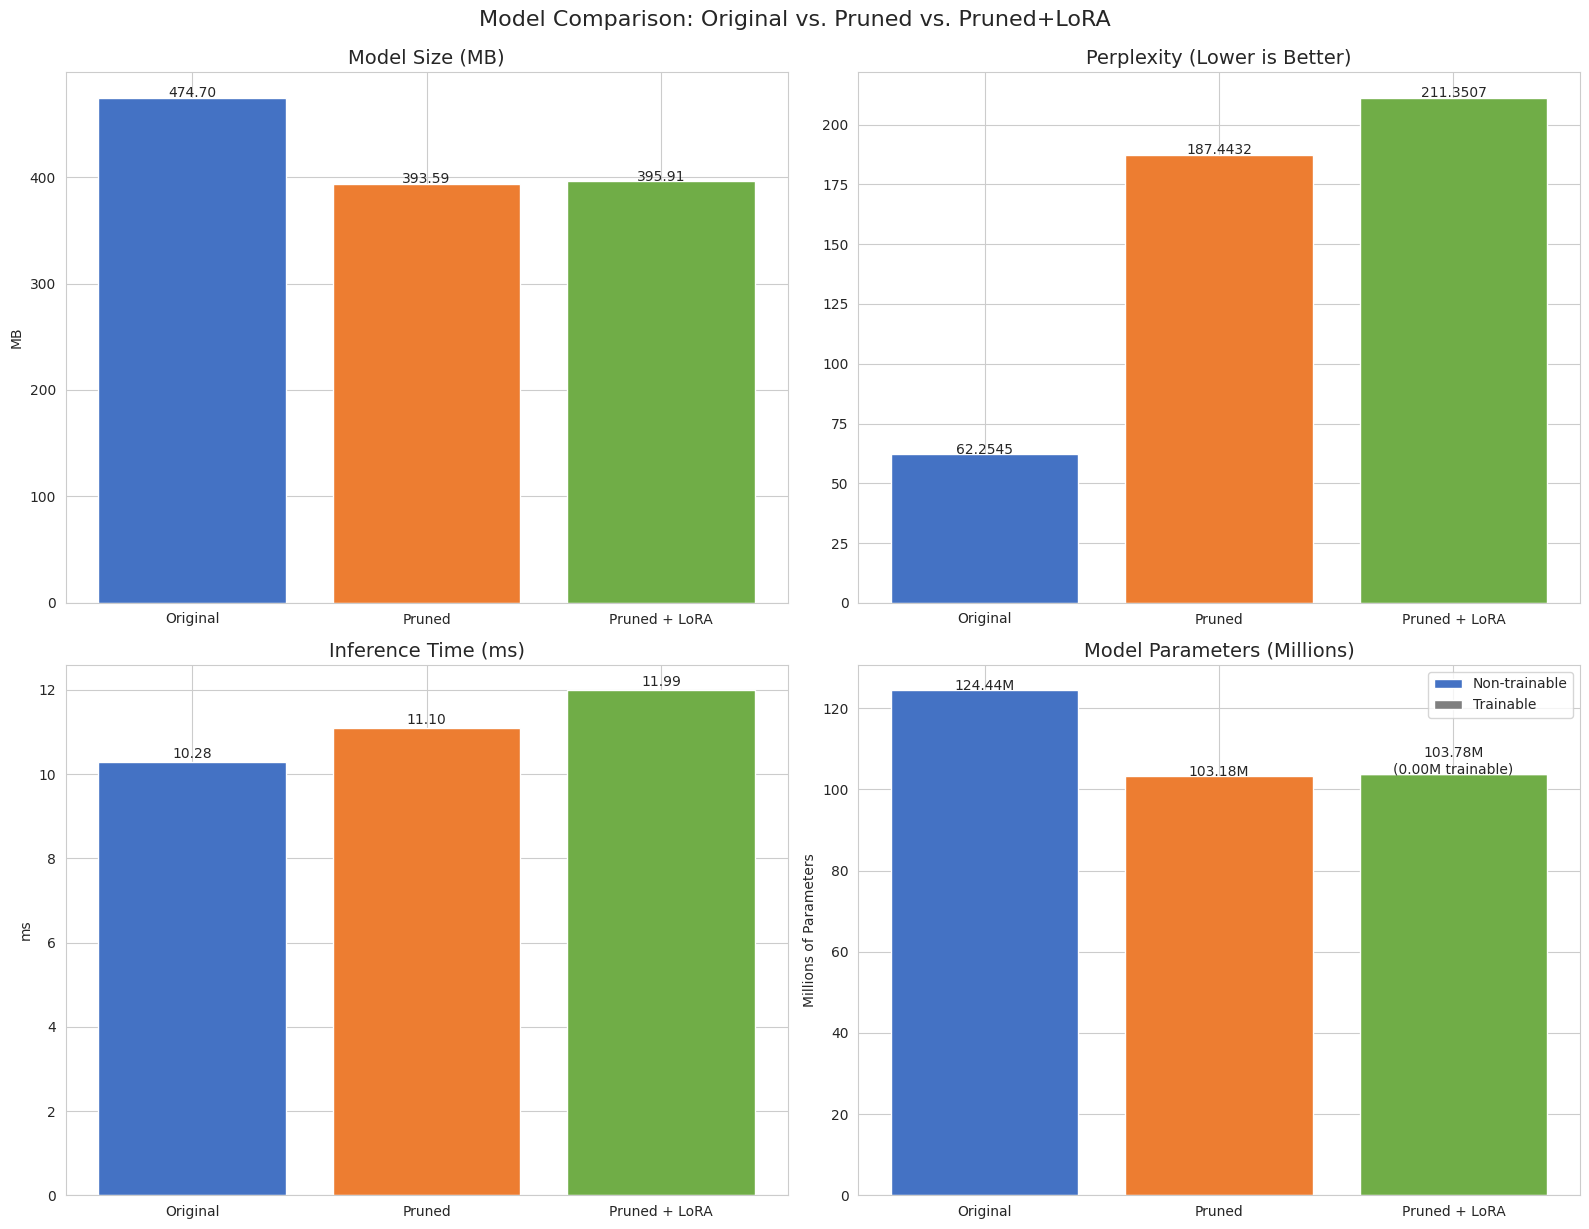

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



GENERATING TEXT SAMPLES FOR QUALITATIVE COMPARISON
--------------------------------------------------------------------------------

Prompt 1: 'In a world where technology and magic coexist,'

Original model output:
In a world where technology and magic coexist, there's no way to really get close to the magic that has so much to do with our lives. We're just not close enough to the magic that we should be. And that's what we're trying to do.

And that's why we've created this project. Because we want to build a world where you can do things that are just not possible.

There's a lot of talk about the magic of the internet.

Pruned model output:
In a world where technology and magic coexist, with a world where the whole universe is one where magic is one where magic is one where magic is one where the entire universe is one where magic is one where magic is one where magic is where the entire universe is one where magic is one where magic is one where magic is one where magic is magic.

In [7]:
def evaluate_all_models(pruning_results, lora_results):
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION AND COMPARISON")
    print("="*50)

    if not lora_results:
        print("LoRA training failed, skipping evaluation.")
        return

    # Extract paths
    model_name = pruning_results['model_name']
    pruned_model_path = pruning_results['pruned_model_path']
    lora_model_path = lora_results['lora_model_path']
    tokenizer = lora_results['tokenizer']
    num_to_prune = pruning_results['num_to_prune']

    # Load original and pruned metrics
    original_metrics = pruning_results['original_metrics']
    pruned_metrics = pruning_results['pruned_metrics']

    # Load models for evaluation
    print("\nLoading models for evaluation...")

    # Original model (for reference)
    print(f"Loading original {model_name} model...")
    original_model = AutoModelForCausalLM.from_pretrained(model_name)
    original_model.to(DEVICE)

    # Pruned model
    print(f"Loading pruned model from {pruned_model_path}...")
    pruned_model = AutoModelForCausalLM.from_pretrained(pruned_model_path)
    pruned_model.to(DEVICE)

    # LoRA fine-tuned model
    print(f"Loading LoRA-tuned model...")
    # First load the base pruned model
    base_model = AutoModelForCausalLM.from_pretrained(pruned_model_path)
    # Then apply the LoRA adapter
    lora_model = PeftModel.from_pretrained(base_model, lora_model_path)
    lora_model.to(DEVICE)

    # Load evaluation dataset - use the same calibration dataset for consistency
    print("\nLoading evaluation dataset...")
    eval_dataset = get_dataset(
        CALIBRATION_DATASET, CALIBRATION_DATASET_CONFIG, CALIBRATION_SPLIT,
        tokenizer, NUM_CALIBRATION_SAMPLES, MAX_CALIBRATION_LENGTH
    )

    # Create sample input for inference time measurement
    sample_input = torch.randint(0, original_model.config.vocab_size, (1, 128)).to(DEVICE)

    # Evaluate LoRA model perplexity and inference time
    print("\nEvaluating LoRA-tuned model...")
    lora_inference_time = time_inference(lora_model, sample_input)
    lora_ppl = calculate_perplexity(lora_model, eval_dataset, DEVICE, "LoRA-tuned Model")

    # Extract parameter counts
    original_param_count = count_parameters(original_model)
    pruned_param_count = count_parameters(pruned_model)
    lora_param_count = count_parameters(lora_model)
    lora_trainable_params = count_parameters(lora_model, only_trainable=True)

    # Get model sizes
    original_model_size = get_model_size_mb(original_model)
    pruned_model_size = get_model_size_mb(pruned_model)
    lora_model_size = get_model_size_mb(lora_model)

    # Collect all metrics
    lora_metrics = {
        'parameters': lora_param_count,
        'trainable_parameters': lora_trainable_params,
        'model_size': lora_model_size,
        'perplexity': lora_ppl,
        'inference_time': lora_inference_time
    }

    # Create comprehensive comparison table
    metrics_df = pd.DataFrame({
        'Metric': ['Parameters (Total)', 'Trainable Parameters', 'Model Size (MB)',
                  'Perplexity', 'Inference Time (ms)'],
        'Original': [original_param_count, 0, original_model_size,
                    original_metrics['perplexity'], original_metrics['inference_time']],
        'Pruned': [pruned_param_count, 0, pruned_model_size,
                  pruned_metrics['perplexity'], pruned_metrics['inference_time']],
        'Pruned + LoRA': [lora_param_count, lora_trainable_params, lora_model_size,
                         lora_ppl, lora_inference_time]
    })

    # Calculate percentage changes relative to original
    metrics_df['Pruned (% change)'] = ((metrics_df['Pruned'] - metrics_df['Original']) /
                                       metrics_df['Original'] * 100).round(2)
    metrics_df['Pruned + LoRA (% change)'] = ((metrics_df['Pruned + LoRA'] - metrics_df['Original']) /
                                             metrics_df['Original'] * 100).round(2)

    # Format numbers for better readability
    metrics_df['Original'] = metrics_df.apply(
        lambda row: f"{row['Original']:,.2f}" if row['Metric'] not in ['Parameters (Total)', 'Trainable Parameters']
        else f"{int(row['Original']):,}", axis=1
    )
    metrics_df['Pruned'] = metrics_df.apply(
        lambda row: f"{row['Pruned']:,.2f}" if row['Metric'] not in ['Parameters (Total)', 'Trainable Parameters']
        else f"{int(row['Pruned']):,}", axis=1
    )
    metrics_df['Pruned + LoRA'] = metrics_df.apply(
        lambda row: f"{row['Pruned + LoRA']:,.2f}" if row['Metric'] not in ['Parameters (Total)', 'Trainable Parameters']
        else f"{int(row['Pruned + LoRA']):,}", axis=1
    )

    metrics_df['Pruned (% change)'] = metrics_df['Pruned (% change)'].apply(lambda x: f"{x:+.2f}%")
    metrics_df['Pruned + LoRA (% change)'] = metrics_df['Pruned + LoRA (% change)'].apply(lambda x: f"{x:+.2f}%")

    print("\nCOMPREHENSIVE MODEL COMPARISON")
    print("-"*80)
    print(metrics_df.to_string(index=False))

    # Create visualization of model comparison
    create_comparison_visualization(original_metrics, pruned_metrics, lora_metrics)

    # Generate text samples for qualitative comparison
    print("\nGENERATING TEXT SAMPLES FOR QUALITATIVE COMPARISON")
    print("-"*80)

    # Define prompts for text generation
    prompts = [
        "In a world where technology and magic coexist,",
        "The solution to climate change requires",
        "The most important skill for the future is",
        "If I could invent one thing, it would be"
    ]

    for i, prompt in enumerate(prompts):
        print(f"\nPrompt {i+1}: '{prompt}'")

        # Generate with original model
        print("\nOriginal model output:")
        generate_and_print_text(original_model, tokenizer, prompt)

        # Generate with pruned model
        print("\nPruned model output:")
        generate_and_print_text(pruned_model, tokenizer, prompt)

        # Generate with LoRA-tuned model
        print("\nPruned + LoRA model output:")
        generate_and_print_text(lora_model, tokenizer, prompt)

        print("-"*50)

    # Save the final comparison report
    report_path = os.path.join(OUTPUT_DIR, "model_comparison_report.txt")
    with open(report_path, "w") as f:
        f.write("MODEL COMPARISON REPORT\n")
        f.write("="*50 + "\n\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Base Model: {model_name}\n")
        f.write(f"Pruning Ratio: {PRUNING_RATIO:.2f}\n")
        f.write(f"Layers Removed: {pruning_results['removed_indices']}\n")
        f.write(f"LoRA Rank: {LORA_RANK}\n\n")
        f.write("METRICS COMPARISON\n")
        f.write("-"*50 + "\n")
        f.write(metrics_df.to_string(index=False) + "\n\n")
        f.write("SUMMARY\n")
        f.write("-"*50 + "\n")

        # Calculate key insights
        param_reduction = (1 - pruned_param_count / original_param_count) * 100
        speed_improvement = (original_metrics['inference_time'] / pruned_metrics['inference_time']) - 1
        ppl_change_pruned = (pruned_metrics['perplexity'] / original_metrics['perplexity']) - 1
        ppl_change_lora = (lora_ppl / original_metrics['perplexity']) - 1

        f.write(f"Parameter Reduction: {param_reduction:.2f}%\n")
        f.write(f"Speed Improvement: {speed_improvement*100:.2f}%\n")
        f.write(f"Perplexity Change (Pruned): {ppl_change_pruned*100:+.2f}%\n")
        f.write(f"Perplexity Change (Pruned+LoRA): {ppl_change_lora*100:+.2f}%\n\n")

        f.write("CONCLUSION\n")
        f.write("-"*50 + "\n")
        if lora_ppl < pruned_metrics['perplexity']:
            f.write("LoRA fine-tuning successfully recovered some of the performance lost during pruning.\n")
        else:
            f.write("LoRA fine-tuning did not improve model performance over the pruned model.\n")

        if pruned_metrics['inference_time'] < original_metrics['inference_time']:
            f.write("Pruning successfully reduced inference time.\n")

        if lora_ppl < original_metrics['perplexity']:
            f.write("The pruned+LoRA model outperforms the original model in terms of perplexity.\n")

    print(f"\nEvaluation complete. Detailed report saved to {report_path}")
    return {
        'original': original_metrics,
        'pruned': pruned_metrics,
        'lora': lora_metrics,
        'report_path': report_path
    }

def create_comparison_visualization(original_metrics, pruned_metrics, lora_metrics):
    """Create a comprehensive visualization comparing all three models."""
    # Set the style for the plots
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))

    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Model Size Comparison
    ax1 = axes[0, 0]
    sizes = [original_metrics['model_size'], pruned_metrics['model_size'], lora_metrics['model_size']]
    labels = ['Original', 'Pruned', 'Pruned + LoRA']
    colors = ['#4472C4', '#ED7D31', '#70AD47']

    ax1.bar(labels, sizes, color=colors)
    ax1.set_title('Model Size (MB)', fontsize=14)
    ax1.set_ylabel('MB')
    for i, v in enumerate(sizes):
        ax1.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

    # 2. Perplexity Comparison
    ax2 = axes[0, 1]
    ppl = [original_metrics['perplexity'], pruned_metrics['perplexity'], lora_metrics['perplexity']]

    ax2.bar(labels, ppl, color=colors)
    ax2.set_title('Perplexity (Lower is Better)', fontsize=14)
    for i, v in enumerate(ppl):
        ax2.text(i, v + 0.1, f"{v:.4f}", ha='center', fontsize=10)

    # 3. Inference Time Comparison
    ax3 = axes[1, 0]
    times = [original_metrics['inference_time'], pruned_metrics['inference_time'], lora_metrics['inference_time']]

    ax3.bar(labels, times, color=colors)
    ax3.set_title('Inference Time (ms)', fontsize=14)
    ax3.set_ylabel('ms')
    for i, v in enumerate(times):
        ax3.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

    # 4. Parameters Count (with split bar for trainable vs. non-trainable)
    ax4 = axes[1, 1]

    # Total parameters for each model
    orig_params = original_metrics['parameters'] / 1_000_000  # Convert to millions
    pruned_params = pruned_metrics['parameters'] / 1_000_000
    lora_total_params = lora_metrics['parameters'] / 1_000_000
    lora_trainable = lora_metrics['trainable_parameters'] / 1_000_000
    lora_frozen = lora_total_params - lora_trainable

    # Plot stacked bar for trainable vs. non-trainable
    ax4.bar(labels[0], orig_params, color=colors[0], label='Non-trainable')
    ax4.bar(labels[1], pruned_params, color=colors[1])
    ax4.bar(labels[2], lora_frozen, color=colors[2])
    ax4.bar(labels[2], lora_trainable, bottom=lora_frozen, color='#7F7F7F', label='Trainable')

    ax4.set_title('Model Parameters (Millions)', fontsize=14)
    ax4.set_ylabel('Millions of Parameters')
    ax4.legend()

    # Add parameter values as text
    ax4.text(0, orig_params + 0.1, f"{orig_params:.2f}M", ha='center', fontsize=10)
    ax4.text(1, pruned_params + 0.1, f"{pruned_params:.2f}M", ha='center', fontsize=10)
    ax4.text(2, lora_total_params + 0.1,
             f"{lora_total_params:.2f}M\n({lora_trainable:.2f}M trainable)",
             ha='center', fontsize=10)

    plt.tight_layout()
    plt.suptitle(f'Model Comparison: Original vs. Pruned vs. Pruned+LoRA', fontsize=16, y=1.02)
    plt.savefig('model_comparison.png', bbox_inches='tight')
    plt.show()

def generate_and_print_text(model, tokenizer, prompt, max_length=100):
    """Generate text from a model and print it."""
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

    # Generate text
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and print the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(generated_text)
    return generated_text

# Run the evaluation after pruning and LoRA training
evaluation_results = evaluate_all_models(pruning_results, lora_results)

# Print final conclusion
if evaluation_results:
    print("\nFINAL CONCLUSION")
    print("="*50)
    print(f"Original Model: PPL = {evaluation_results['original']['perplexity']:.4f}, Size = {evaluation_results['original']['model_size']:.2f} MB")
    print(f"Pruned Model: PPL = {evaluation_results['pruned']['perplexity']:.4f}, Size = {evaluation_results['pruned']['model_size']:.2f} MB")
    print(f"Pruned+LoRA Model: PPL = {evaluation_results['lora']['perplexity']:.4f}, Size = {evaluation_results['lora']['model_size']:.2f} MB")

    # Summarize key findings
    param_reduction = (1 - evaluation_results['pruned']['parameters'] / evaluation_results['original']['parameters']) * 100
    speed_improvement = (evaluation_results['original']['inference_time'] / evaluation_results['pruned']['inference_time']) * 100 - 100
    ppl_change_lora = (evaluation_results['lora']['perplexity'] / evaluation_results['original']['perplexity']) * 100 - 100

    print(f"\nKey Findings:")
    print(f"- Parameter reduction through pruning: {param_reduction:.2f}%")
    print(f"- Inference speed improvement: {speed_improvement:.2f}%")
    print(f"- Final perplexity change: {ppl_change_lora:+.2f}%")

    if evaluation_results['lora']['perplexity'] < evaluation_results['pruned']['perplexity']:
        recovery = (evaluation_results['pruned']['perplexity'] - evaluation_results['lora']['perplexity']) / (evaluation_results['pruned']['perplexity'] - evaluation_results['original']['perplexity']) * 100
        print(f"- LoRA recovered {recovery:.2f}% of performance lost during pruning")

    print("\nDetailed report saved to:", evaluation_results['report_path'])